In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'<<{_str}>>:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

# Model 설계 workfolw

In [ ]:
!pip -q install lightning torchinfo  # Wall time: 1min 32s

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch import nn, torch_version
from torch.nn import functional as F
import torch.optim as optim

import lightning as L
from lightning.pytorch.accelerators import accelerator
import torchmetrics
from torchmetrics import functional as FM
from torchinfo import summary

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams["font.size"] = "8"

torch.__version__,L.__version__,torchmetrics.__version__,torch_version.__version__

('2.6.0+cu124', '2.5.1.post0', '1.7.2', '2.6.0+cu124')

### DataModule 만들기

https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09

In [ ]:
import os
num_workers = os.cpu_count() // 2
num_workers

4

[ num_workers 결정 ]
* num_workers를 높이면 데이터 로드가 병렬화되어 처리 속도가 증가할 수 있지만,  
너무 높을 경우 컨텍스트 스위칭 비용이 증가하고, CPU가 과부하 상태가 될 수 있음
* 데이터 로드가 I/O 병목(예: 디스크에서의 읽기 속도 제한)이라면, 적당한 수준에서 멈추는 것이 좋음

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils import data
from torch.utils.data import DataLoader

class MNISTDataModule(L.LightningDataModule):
  def __init__(self, data_dir: str = '', batch_size: int = 32):
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size

  def setup(self, stage):
    # transforms for images
    transform=transforms.Compose([transforms.ToTensor(), # 1/255,tensor로 변환
                                  transforms.Normalize((0.1307,), (0.3081,))])
    self.mnist_test = MNIST(self.data_dir, train=False, transform=transform, download=True)
    mnist_full = MNIST(self.data_dir, train=True, transform=transform, download=True)
    self.mnist_train, self.mnist_val = data.random_split(mnist_full, [55000, 5000])

  def train_dataloader(self):
    return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=num_workers)
  def val_dataloader(self):
    return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=num_workers)
  def test_dataloader(self):
    return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=num_workers)

data_module = MNISTDataModule(batch_size=256)

In [ ]:
class Wrap_10(L.LightningModule):
    def predict_step(self, x, batch_idx):
        y_pred = self(x)
        y_pb = F.softmax(y_pred)
        return y_pb

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        mse = FM.mean_squared_error(torch.argmax(y_pred, dim=1), y)
        metrics={'loss': loss, 'acc':acc, 'mse': mse}
        self.log_dict(metrics,prog_bar=True)#on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.cross_entropy(y_pred, y)
        acc = FM.accuracy(y_pred, y, task="multiclass",num_classes=10)
        mse = FM.mean_squared_error(torch.softmax(y_pred, dim=1), F.one_hot(y,num_classes=10))
        metrics={'val_loss': loss, 'val_acc':acc, 'val_mse': mse}
        self.log_dict(metrics) #on_step=False, on_epoch=True

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

## Model 정의

In [ ]:
class Model(Wrap_10):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, 2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(6*6*64, 10)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

model = Model()
summary(model, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Conv2d: 2-1                       [8, 32, 13, 13]           320
│    └─ReLU: 2-2                         [8, 32, 13, 13]           --
│    └─Conv2d: 2-3                       [8, 64, 6, 6]             18,496
│    └─ReLU: 2-4                         [8, 64, 6, 6]             --
│    └─Flatten: 2-5                      [8, 2304]                 --
│    └─Linear: 2-6                       [8, 10]                   23,050
Total params: 41,866
Trainable params: 41,866
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 5.94
Input size (MB): 0.03
Forward/backward pass size (MB): 0.49
Params size (MB): 0.17
Estimated Total Size (MB): 0.69

In [ ]:
model

Model(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=2304, out_features=10, bias=True)
  )
)

In [ ]:
%%time
model = Model()
trainer = L.Trainer(max_epochs=3,enable_model_summary=False)
trainer.fit(model, data_module)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


CPU times: user 6.43 s, sys: 1.42 s, total: 7.85 s
Wall time: 12.9 s


## Loss / Metric 함수

**내장 Loss Func.**
> torch.nn.functional
* mse_loss      : element-wise mean squared error.
* cross_entropy : cross entropy loss between input(logit) and target(prob.).
* binary_cross_entropy : Binary Cross Entropy between the target and input probabilities.
* binary_cross_entropy_with_logits :  Binary Cross Entropy between target and input logits.
* kl_div : Kullback-Leibler divergence Loss
* l1_loss : mean element-wise absolute value difference.
* smooth_l1_loss : uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise.
* nll_loss : negative log likelihood loss.
* poisson_nll_loss : Poisson negative log likelihood loss.
* gaussian_nll_loss : Gaussian negative log likelihood loss.
...

**Matric Func.**
> [torchmetrics](https://lightning.ai/docs/torchmetrics/stable/)

## configure_optimizers( )
**Optimization Algorithms + Learning rate schedueling**


Adadelta : Implements Adadelta algorithm.

Adagrad  : Implements Adagrad algorithm.

Adam : Implements Adam algorithm.

NAdam : Implements NAdam algorithm.

AdamW : Implements AdamW algorithm.  

RAdam : Implements RAdam algorithm.  

RMSprop : Implements RMSprop algorithm.

SGD : Implements stochastic gradient descent (optionally with momentum).  
....
```python
torch.optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, *, maximize=False)
torch.optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False, *, maximize=False)  
torch.optim.AdamW(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False, *, maximize=False, foreach=None, capturable=False, differentiable=False, fused=None)  
torch.optim.RAdam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, *, foreach=None, differentiable=False)
```

**기본 구조**

In [ ]:
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler

# no learning rate scheduler
def configure_optimizers(self):
    return Adam(self.parameters(), lr=1e-3)

# multiple optimizer case (e.g.: GAN)
def configure_optimizers(self):
    gen_opt = Adam(self.model_gen.parameters(), lr=0.01)
    dis_opt = Adam(self.model_dis.parameters(), lr=0.02)
    return gen_opt, dis_opt

# multi-optimizer has its own scheduler(step decay)
def configure_optimizers(self):
    gen_opt = Adam(self.model_gen.parameters(), lr=0.01)
    dis_opt = Adam(self.model_dis.parameters(), lr=0.02)
    gen_sch = {
        'scheduler': lr_scheduler.ExponentialLR(gen_opt, 0.99),
        'interval': 'step'  # called after each training step or 'epoch'
    }
    dis_sch = lr_scheduler.ExponentialLR(dis_opt, 0.99) # called every epoch
    return [gen_opt, dis_opt], [gen_sch, dis_sch]

### Learning rate scheduling

In [ ]:
def configure_optimizers(self):
    optimizer = Adam(self.model_gen.parameters(), lr=0.05)

## StepLR : step_size단위로 lr <- lr*gamma
    lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    # Assuming optimizer uses lr = 0.05 for all groups
    # lr = 0.05     if epoch < 30
    # lr = 0.005    if 30 <= epoch < 60
    # lr = 0.0005   if 60 <= epoch < 90
    # ...

## MultiStepLR : milestones list로 step down할 epoch 지정
    lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
    # Assuming optimizer uses lr = 0.05 for all groups
    # lr = 0.05     if epoch < 30
    # lr = 0.005    if 30 <= epoch < 80
    # lr = 0.0005   if epoch >= 80

## LambdaLR-1 : lr_strat에 곱해질 함수를 지정
    lambda1 = lambda epoch: 0.95 ** epoch
    lr_scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda = lambda1)
    # lr = lr_start * 0.95**epoch

## LambdaLR-2
    def func(epoch):
        return 0.5 ** (epoch//10)
    lr_scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda = func)
    # lr = lr_start * 0.5**(epoch//10)

## LambdaLR-3 : parameter group별 lr-scheduling 적용
    # Assuming optimizer has two groups.
    lambda1 = lambda epoch: 0.5 ** (epoch // 10)
    lambda2 = lambda epoch: 0.95 ** epoch
    lr_scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda1, lambda2])

## ExponentialLR
    gamma=0.98
    lr_scheduler=lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=- 1, verbose=False)
    return [optimizer], [lr_scheduler]

### LR scheduling 적용

In [ ]:
def lr_polt(lr_s,epochs=100,lr_start=0.01, label=""):
  lr=[]
  for step in range(epochs):
      lr.append(lr_s(step)*lr_start)
  plt.plot(lr, linestyle='--', label= label)
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
lr = 0.005
class MyModel(Model):
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        return optimizer

model = MyModel()
summary(model, input_size=(8, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [8, 10]                   --
├─Sequential: 1-1                        [8, 10]                   --
│    └─Conv2d: 2-1                       [8, 32, 13, 13]           320
│    └─ReLU: 2-2                         [8, 32, 13, 13]           --
│    └─Conv2d: 2-3                       [8, 64, 6, 6]             18,496
│    └─ReLU: 2-4                         [8, 64, 6, 6]             --
│    └─Flatten: 2-5                      [8, 2304]                 --
│    └─Linear: 2-6                       [8, 10]                   23,050
Total params: 41,866
Trainable params: 41,866
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 5.94
Input size (MB): 0.03
Forward/backward pass size (MB): 0.49
Params size (MB): 0.17
Estimated Total Size (MB): 0.69

In [ ]:
data_module = MNISTDataModule(batch_size=256)

In [ ]:
%%time
model = MyModel()
epoch=30
name="model_defaults"
logger = L.pytorch.loggers.CSVLogger("logs", name=name)
trainer = L.Trainer(max_epochs=epoch, logger=logger ,overfit_batches=0.4,enable_model_summary=False)
trainer.fit(model, data_module)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


CPU times: user 28.8 s, sys: 11.2 s, total: 40 s
Wall time: 1min 1s


Wall time: 48.8 s

In [ ]:
v_num = logger.version
meric_file = f'./logs/{name}/version_{v_num}/metrics.csv'
history = pd.read_csv(meric_file)
print(meric_file) # ./logs/model_defaults/version_0/metrics.csv

./logs/model_defaults/version_0/metrics.csv


In [ ]:
h1 = history.drop('step', axis=1).groupby('epoch').last()
max_ = h1['val_acc'].max()

plt.figure(figsize=(10,3))
title = "No Schedule"
plt.subplot(121)
plt.title(f"{title}\nMax Val_Acc:{max_:.4f}")
plt.plot(h1['acc'], label='acc')
plt.plot(h1['val_acc'], label='val_acc')
#plt.ylim(0.7, 1)
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("Loss")
plt.plot(h1['loss'], label='loss')
plt.plot(h1['val_loss'], label='val_loss')
plt.semilogy()
plt.legend()
plt.grid()
plt.show()

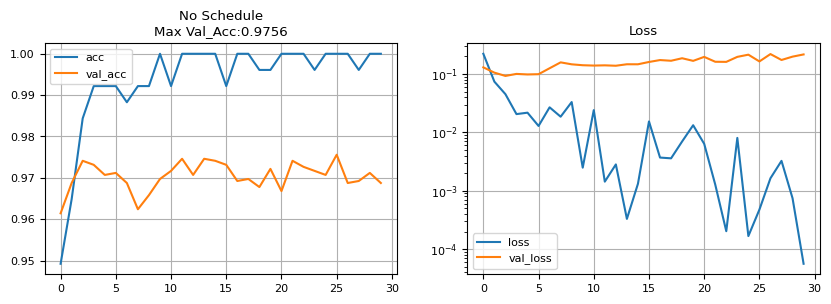

In [ ]:
#lr = 0.005
decay_steps = 5
gamma=0.3

exponential_decay_step = lambda epoch: gamma**(epoch // decay_steps)

lr_polt(exponential_decay_step,epochs=epoch,lr_start=lr,label="exp_decay")

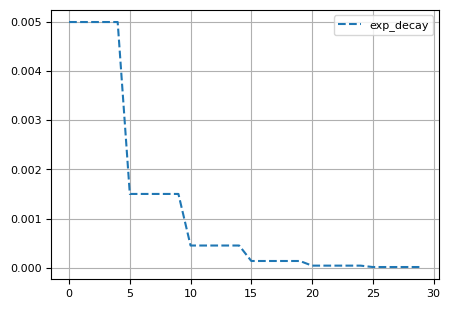

**Custom lr-scheduler 적용**

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler
# exponential_decay_step = lambda epoch: gamma**(epoch // decay_steps)

class Model_expDeacy(Model):
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        lr_s = lr_scheduler.LambdaLR(optimizer,
                                     lr_lambda = exponential_decay_step, verbose=True)
        return [optimizer], [lr_s]

In [ ]:
model_exp = Model_expDeacy()
name2="model_exp_decay"
logger = L.pytorch.loggers.CSVLogger("logs", name=name2)
trainer = L.Trainer(max_epochs=epoch, logger=logger ,overfit_batches=0.4,enable_model_summary=False)
trainer.fit(model_exp, data_module)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [ ]:
v_num2 = logger.version
meric_file = f'./logs/{name2}/version_{v_num2}/metrics.csv'
history2 = pd.read_csv(meric_file)

In [ ]:
h1 = history.drop('step', axis=1).groupby('epoch').last()
h2 = history2.drop('step', axis=1).groupby('epoch').last()
max_1 = h1['val_acc'].max()
max_2 = h2['val_acc'].max()

titles = "Base / lr-schedule"
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.title(f"{titles}\n Max Val_Acc:{max_1:.4f} / {max_2:.4f}")
plt.plot(h1['acc'],'--', label='acc')
plt.plot(h1['val_acc'], label='val_acc')
plt.plot(h2['acc'],'--', label='acc2')
plt.plot(h2['val_acc'], label='val_acc2')
#plt.ylim(0.7, 1)
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("Loss")
plt.plot(h1['loss'],'--', label='loss')
plt.plot(h1['val_loss'], label='val_loss')
plt.plot(h2['loss'],'--', label='loss2')
plt.plot(h2['val_loss'], label='val_loss2')
plt.semilogy()
plt.legend()
plt.grid()
plt.show()

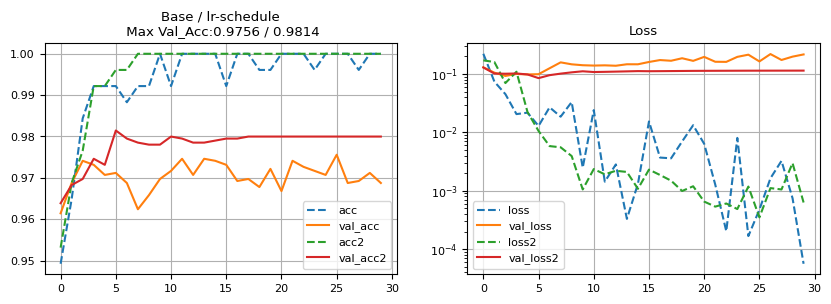

# L.Trainer( )   
https://lightning.ai/docs/pytorch/latest/common/trainer.html#

In [ ]:
!rm -rf ./logs

### [Call Back](https://lightning.ai/docs/pytorch/stable/api_references.html#callbacks)

**Callbacks API(Built-in Callbacks)**

* EarlyStopping : Monitor a metric and stop training when it stops improving.
* ModelCheckpoint : Save the model periodically by monitoring a quantity.
---
* LambdaCallback : Create a simple callback on the fly using lambda functions.
* Callback : Abstract base class used to build new callbacks.
---
* ModelSummary : Generates a summary of all layers in a LightningModule.
* RichModelSummary : Generates a summary of all layers in a LightningModule with rich text formatting.
---
* LearningRateMonitor : Automatically monitor and logs learning rate for learning rate schedulers during training.
* TQDMProgressBar : This is the default progress bar used by Lightning.
* ProgressBarBase : The base class for progress bars in Lightning.
* RichProgressBar : Create a progress bar with rich text formatting.
* DeviceStatsMonitor : Automatically monitors and logs device stats during training stage.
* Timer : The Timer callback tracks the time spent in the training, validation, and test loops and interrupts the Trainer if the given time limit for the training loop is reached.
---
* ModelPruning : Model pruning Callback, using PyTorch's prune utilities.
* QuantizationAwareTraining : Quantization allows speeding up inference and decreasing memory requirements by performing computations and storing tensors at lower bitwidths (such as INT8 or FLOAT16) than floating point precision.
* GradientAccumulationScheduler : Change gradient accumulation factor according to scheduling.
* StochasticWeightAveraging : Implements the Stochastic Weight Averaging (SWA) Callback to average a model.



#### EarlyStopping

In [ ]:
from lightning.pytorch.callbacks import EarlyStopping

In [ ]:
model = Model()

logger = L.pytorch.loggers.CSVLogger("logs", name="model_custom_losses")
trainer = L.Trainer(max_epochs=100, logger=logger,
                     callbacks=[EarlyStopping(monitor="val_acc", mode="max", patience=5)],
                     overfit_batches=0.3,enable_model_summary=False)
trainer.fit(model, data_module)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

#### ModelCheckPoint 저장하기   
https://pytorch-lightning.readthedocs.io/en/1.6.5/common/checkpointing.html

 Parameters & default values


In [ ]:
from lightning.pytorch.callbacks import ModelCheckpoint

model = Model()

logger = L.pytorch.loggers.CSVLogger("logs", name="mnist")
checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath=f'{logger.log_dir}/ckpt', ## 버전별로 저장됨 ##
    filename='{epoch:02d}-{val_acc:.4f}',
    save_top_k=1)
trainer = L.Trainer(max_epochs=10, logger=logger, callbacks=[checkpoint_callback],
                    overfit_batches=0.3,enable_model_summary=False)
trainer.fit(model, data_module)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
print(f'{logger.log_dir}/ckpt')
%ls  {logger.log_dir}/ckpt

logs/mnist/version_0/ckpt
'epoch=00-val_acc=0.9017.ckpt'


In [ ]:
## path와 성능을 보여줌
checkpoint_callback.best_k_models

{'/content/logs/mnist/version_0/ckpt/epoch=00-val_acc=0.9017.ckpt': tensor(0.9017, device='cuda:0')}

In [ ]:
## path만 가져 옴
checkpoint_callback.best_model_path

'/content/logs/mnist/version_0/ckpt/epoch=00-val_acc=0.9017.ckpt'

In [ ]:
### best_model_path에서 모델 읽어 오기
checkpoint_path = checkpoint_callback.best_model_path
# 모델 읽어오기
new_model = Model.load_from_checkpoint(checkpoint_path)
trainer.validate(new_model, data_module)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9049479365348816     │
│         val_loss          │    0.31276118755340576    │
│          val_mse          │   0.014335359446704388    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.31276118755340576,
  'val_acc': 0.9049479365348816,
  'val_mse': 0.014335359446704388}]

### 모델 저장, 복원

#### torch.save(), torch.load()

In [ ]:
import os
os.makedirs('./aicamp', exist_ok=True)

torch.save(model, './aicamp/model_save.pt')

## v2.6에서 변경됨 weights_only=False 필수
new_model = torch.load('./aicamp/model_save.pt',weights_only=False)

trainer = L.Trainer()
trainer.validate(new_model, data_module)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9807999730110168     │
│         val_loss          │    0.06774517893791199    │
│          val_mse          │   0.003125153249129653    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.06774517893791199,
  'val_acc': 0.9807999730110168,
  'val_mse': 0.003125153249129653}]

# LightningModule, Training class Summary

## Trainer flags

```python
trainer = L.Trainer(flags)
flags :
max_epochs=1000
min_epochs=1
max_steps=100
accelerator="auto"        # CPU,GPU,TPU,auto
deterministic=True        # reproducibility
callbacks=[Callback()]
check_val_every_n_epoch=1 #
gradient_clip_val=0.0
limit_train_batches=0.25  # 25% training / epoch
limit_test_batches=0.25
limit_val_batches=0.25
log_every_n_steps=50
logger=logger
max_time="00:12:00:00"
overfit_batches=10 #or 0.1:
# overfits only 10th batch or 10% of the training set.
precision=32
enable_progress_bar=True
weights_summary="top"     # full,None
enable_model_summary=True

```

### Device Handling

```python
## Multi-GPU Training
trainer = L.Trainer(gpus=8, distributed_backend='dp')

## TPU Training
trainer = L.Trainer(tpu_cores=[5])
```

### Automatic Mixed Precision  
PyTorch, TensorFlow, Lightning 등에서는 AMP를 통해 학습을 자동으로 FP32 + FP16(bfloat16) 혼합으로 실행

이로 인해 메모리 사용량 감소 (최대 50%), 속도 2~3배 향상 가능

**bfloat : brain floating point**

In [ ]:
torch.cuda.is_available(), torch.cuda.is_bf16_supported()

(True, True)

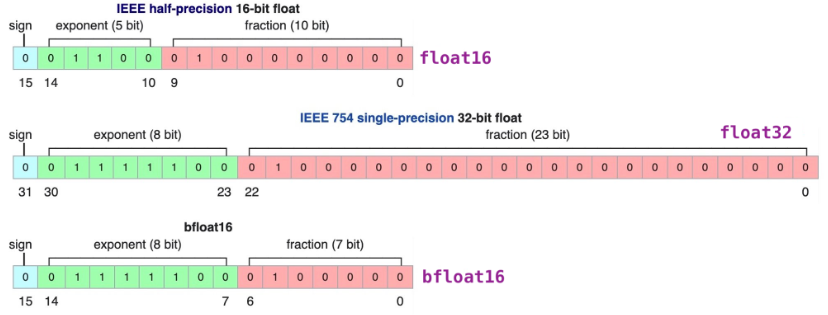

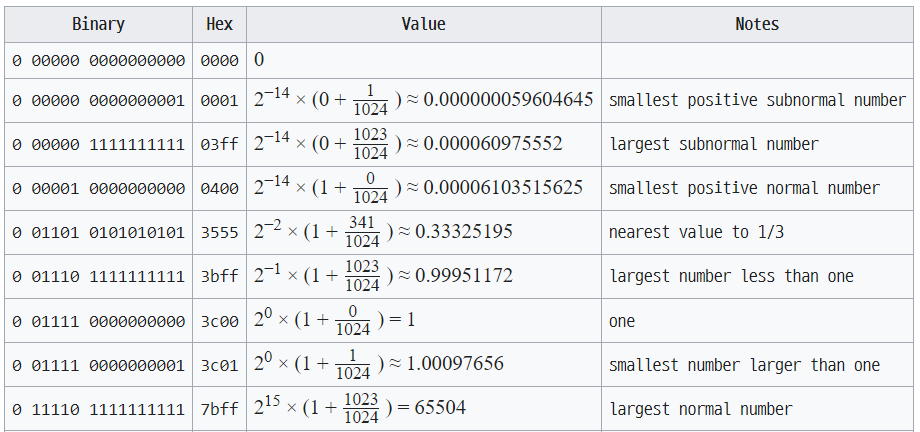

* Trainer에서 지정하기  
https://lightning.ai/docs/pytorch/stable/common/trainer.html#precision

In [ ]:
# 64-bit precision
trainer = L.Trainer(precision=64)
# default used by the Trainer
trainer = L.Trainer(precision=32)
# 16-bit precision (weights: float16)
trainer = L.Trainer(precision="16-true", devices=1)
# 16-bit mixed precision (weights: float32)
trainer = L.Trainer(precision="16-mixed", devices=1)
# 16-bit bfloat precision (weights: bfloat16)
trainer = L.Trainer(precision="bf16-true")
# 16-bit bfloat mixed precision (weights: float32)
trainer = L.Trainer(precision="bf16-mixed")

## bfloat16 : "A Study of BFLOAT16 for Deep Learning Training" (2019)  


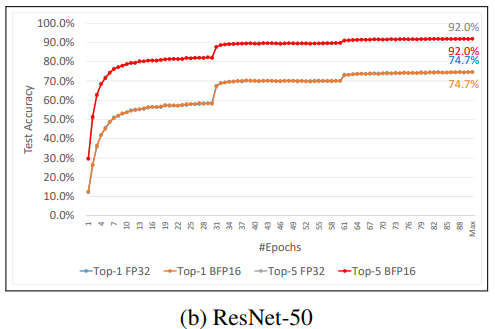

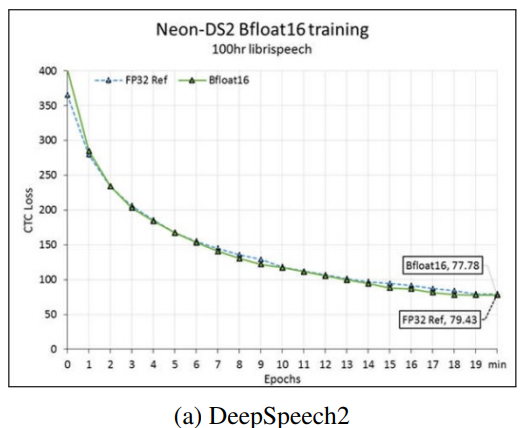